In [362]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import collections
import itertools

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score

import gensim

from wordcloud import WordCloud

from nltk.stem.porter import *

In [363]:
df_train= r"C:\Users\Julian\Desktop\Coding Stuff\Machine Learning\COVID19 NLP\Corona_NLP_train.csv"
df_train= pd.read_csv(df_train, encoding='latin-1')
df_test = r"C:\Users\Julian\Desktop\Coding Stuff\Machine Learning\COVID19 NLP\Corona_NLP_test.csv"
df_test = pd.read_csv(df_test, encoding='latin-1')

df = pd.concat([df_test, df_train], ignore_index=True)
df = df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1)
# df.reset_index()
df

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...
44950,Airline pilots offering to stock supermarket s...,Neutral
44951,Response to complaint not provided citing COVI...,Extremely Negative
44952,You know itÂs getting tough when @KameronWild...,Positive
44953,Is it wrong that the smell of hand sanitizer i...,Neutral


In [364]:
# GOING TO USE VECTORIZE TO SPEED UP SENTIMENT CLASSIFIER
# I AM GOING TO TRY IT WITH JUST 3 POSSIBLE SENTIMENTS
New = []
def SentConvert(Sent):
    if Sent == 'Extremely Negative':
        Sent = 0
    elif Sent == 'Negative':
        Sent = 0
    elif Sent == 'Neutral':
        Sent = 1
    elif Sent == 'Positive':
        Sent = 2
    elif Sent == 'Extremely Positive':
        Sent = 2
    New.append(Sent)
np.vectorize(SentConvert)(df['Sentiment'])
New.pop(0)
New = pd.Series(New)
df = df.drop('Sentiment', axis=1)
df = pd.concat([df, New], axis=1, ignore_index=True)
df.columns = ['OriginalTweet', 'Sentiment']
df

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,0
1,When I couldn't find hand sanitizer at Fred Me...,2
2,Find out how you can protect yourself and love...,2
3,#Panic buying hits #NewYork City as anxious sh...,0
4,#toiletpaper #dunnypaper #coronavirus #coronav...,1
...,...,...
44950,Airline pilots offering to stock supermarket s...,1
44951,Response to complaint not provided citing COVI...,0
44952,You know itÂs getting tough when @KameronWild...,2
44953,Is it wrong that the smell of hand sanitizer i...,1


In [365]:
def clean(text, pattern):
    r = re.findall(pattern, text)
    for i in r:
        text = re.sub(i, '', text)
    return text

In [366]:
df['KeyTweet'] = np.vectorize(clean)(df['OriginalTweet'],'@[\w]*')
df['KeyTweet'] = df['KeyTweet'].str.replace('[^a-zA-Z#]', ' ')
# df['KeyTweet'] = df['KeyTweet'].apply(lambda df: ' '.join([w for w in df.split() if len(w)>3]))
df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'], 'Â')
df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'#')
df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'')
df

,OriginalTweet,Sentiment,KeyTweet
0,TRENDING: New Yorkers encounter empty supermar...,0,TRENDING: New Yorkers encounter empty supermar...
1,When I couldn't find hand sanitizer at Fred Me...,2,When I couldn't find hand sanitizer at Fred Me...
2,Find out how you can protect yourself and love...,2,Find out how you can protect yourself and love...
3,#Panic buying hits #NewYork City as anxious sh...,0,Panic buying hits NewYork City as anxious shop...
4,#toiletpaper #dunnypaper #coronavirus #coronav...,1,toiletpaper dunnypaper coronavirus coronavirus...
...,...,...,...
44950,Airline pilots offering to stock supermarket s...,1,Airline pilots offering to stock supermarket s...
44951,Response to complaint not provided citing COVI...,0,Response to complaint not provided citing COVI...
44952,You know itÂs getting tough when @KameronWild...,2,You know its getting tough when is rationing...
44953,Is it wrong that the smell of hand sanitizer i...,1,Is it wrong that the smell of hand sanitizer i...


In [367]:
# Drop all instances of 'https'
print(df.iloc[1,2])
for i in range(len(df)):
    df.iloc[i,2] = (re.sub(r'https\S+', '', df.iloc[i,2]))
print(df.iloc[1,2])
df


When I couldn't find hand sanitizer at Fred Meyer, I turned to Amazon. But $114.97 for a 2 pack of Purell??!!Check out how  coronavirus concerns are driving up prices. https://t.co/ygbipBflMY
When I couldn't find hand sanitizer at Fred Meyer, I turned to Amazon. But $114.97 for a 2 pack of Purell??!!Check out how  coronavirus concerns are driving up prices. 


,OriginalTweet,Sentiment,KeyTweet
0,TRENDING: New Yorkers encounter empty supermar...,0,TRENDING: New Yorkers encounter empty supermar...
1,When I couldn't find hand sanitizer at Fred Me...,2,When I couldn't find hand sanitizer at Fred Me...
2,Find out how you can protect yourself and love...,2,Find out how you can protect yourself and love...
3,#Panic buying hits #NewYork City as anxious sh...,0,Panic buying hits NewYork City as anxious shop...
4,#toiletpaper #dunnypaper #coronavirus #coronav...,1,toiletpaper dunnypaper coronavirus coronavirus...
...,...,...,...
44950,Airline pilots offering to stock supermarket s...,1,Airline pilots offering to stock supermarket s...
44951,Response to complaint not provided citing COVI...,0,Response to complaint not provided citing COVI...
44952,You know itÂs getting tough when @KameronWild...,2,You know its getting tough when is rationing...
44953,Is it wrong that the smell of hand sanitizer i...,1,Is it wrong that the smell of hand sanitizer i...


In [368]:
df['KeyTweet'] = df['KeyTweet'].apply(lambda df: ' '.join([w for w in df.split() if len(w)>3]))

In [369]:
# Key = df['KeyTweet']
# for i in range(len(Key)):
#     print(Key[i])

In [370]:
# Drop all empy sets
Drop = []
for i in range(len(df)):
    if len(df.iloc[i,2]) == 0:
        Drop.append(i)
for i in reversed(range(len(Drop))):
    df = df.drop(int(Drop[i]), axis=0)
df = df.reset_index(drop=True)    

In [371]:
# Drop all duplicated
print(df.shape)
df = df.drop_duplicates(subset=['KeyTweet'])
print(df.shape)
df.iloc[4790:4800]
df = df.reset_index(drop=True)   

(44934, 3)
(44699, 3)


In [372]:
#Tokenize the tweets
SegmentedTweet = df['KeyTweet'].apply(lambda x:x.split())
stemmer = PorterStemmer()
SegmentedTweet = SegmentedTweet.apply(lambda x: [stemmer.stem(i) for i in x])
SegmentedTweet.head()

0    [trending:, yorker, encount, empti, supermarke...
1    [when, couldn't, find, hand, sanit, fred, meye...
2    [find, protect, yourself, love, one, from, cor...
3    [panic, buy, hit, newyork, citi, anxiou, shopp...
4    [toiletpap, dunnypap, coronaviru, coronavirusa...
Name: KeyTweet, dtype: object

In [373]:
# These are the sentiment filtered tokenize

Negdf = df[df['Sentiment']==0]
Neudf = df[df['Sentiment']==1]
Posdf = df[df['Sentiment']==2]

NegSegmentedTweet = Negdf['KeyTweet'].apply(lambda x:x.split())
NeuSegmentedTweet = Neudf['KeyTweet'].apply(lambda x:x.split())
PosSegmentedTweet = Posdf['KeyTweet'].apply(lambda x:x.split())

NegSegmentedTweet = NegSegmentedTweet.apply(lambda x: [stemmer.stem(i) for i in x])
NeuSegmentedTweet = NeuSegmentedTweet.apply(lambda x: [stemmer.stem(i) for i in x])
PosSegmentedTweet = PosSegmentedTweet.apply(lambda x: [stemmer.stem(i) for i in x])


In [374]:
AllWordsAlone = list(itertools.chain.from_iterable(SegmentedTweet))

NegAllWordsAlone = list(itertools.chain.from_iterable(NegSegmentedTweet))
NeuAllWordsAlone = list(itertools.chain.from_iterable(NeuSegmentedTweet))
PosAllWordsAlone = list(itertools.chain.from_iterable(PosSegmentedTweet))

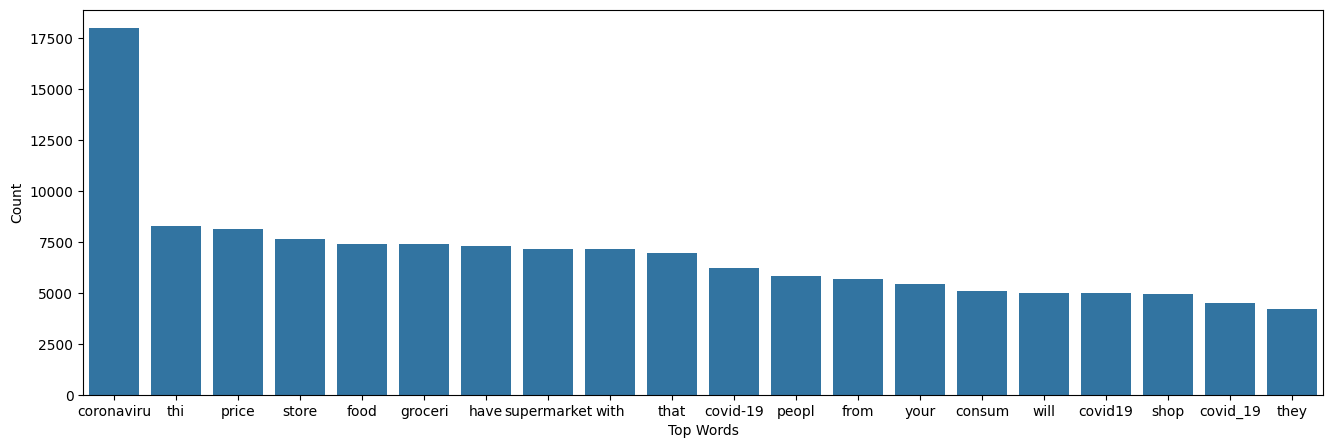

In [375]:
ListOfWords = nltk.FreqDist(AllWordsAlone)
df0 = pd.DataFrame({'Top Words': list(ListOfWords.keys()), 'Count':list(ListOfWords.values())})
df0 = df0.nlargest(columns='Count', n=20)
plt.figure(figsize=(16,5))
ax= sns.barplot(data=df0, x='Top Words', y='Count')
ax.set(ylabel= 'Count')
plt.show()


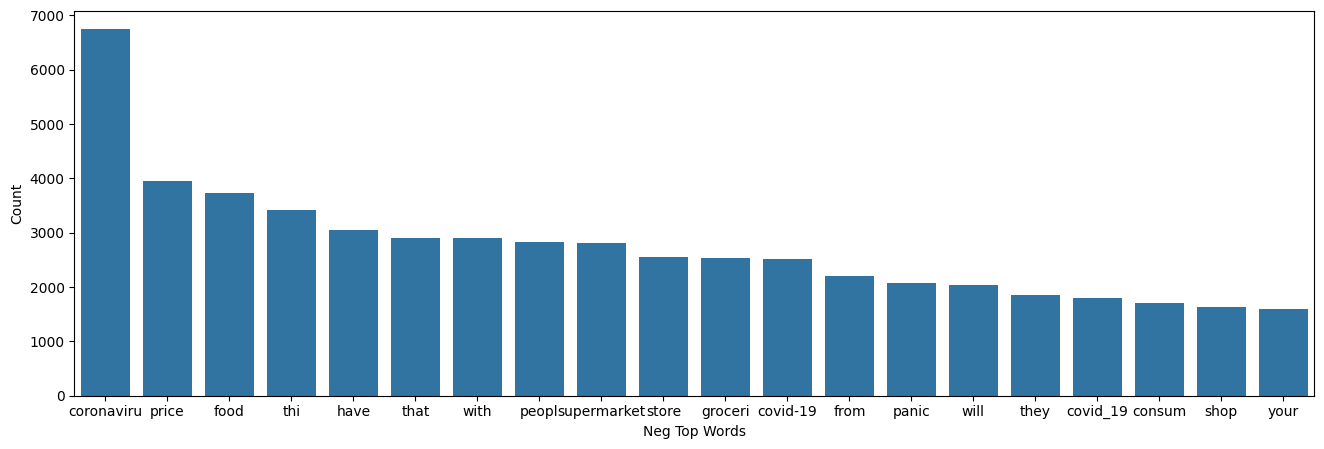

In [376]:
NegListOfWords = nltk.FreqDist(NegAllWordsAlone)
df1 = pd.DataFrame({'Neg Top Words': list(NegListOfWords.keys()), 'Count':list(NegListOfWords.values())})
df1 = df1.nlargest(columns='Count', n=20)
plt.figure(figsize=(16,5))
ax= sns.barplot(data=df1, x='Neg Top Words', y='Count')
ax.set(ylabel= 'Count')
plt.show()

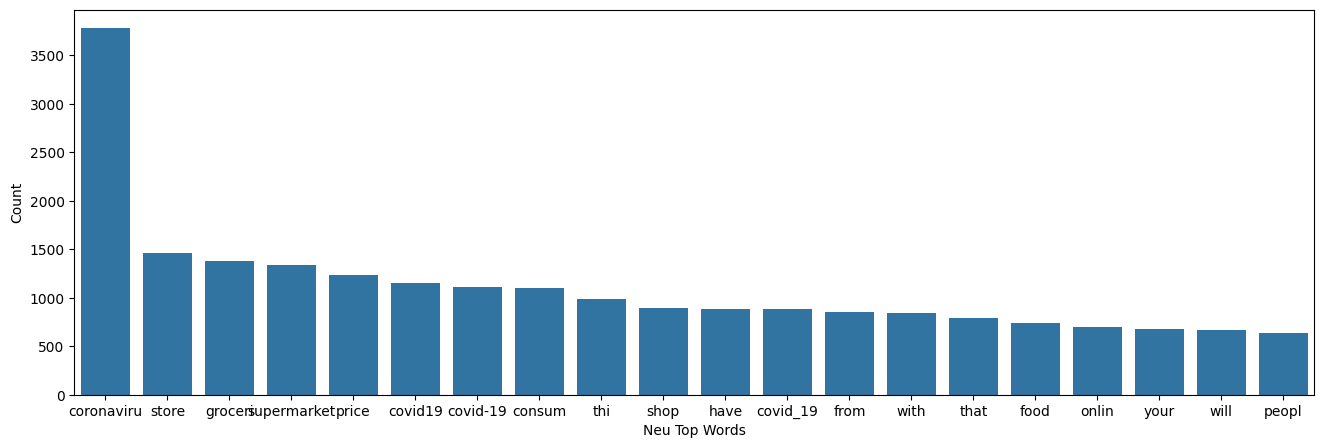

In [377]:
NeuListOfWords = nltk.FreqDist(NeuAllWordsAlone)
df2 = pd.DataFrame({'Neu Top Words': list(NeuListOfWords.keys()), 'Count':list(NeuListOfWords.values())})
df2 = df2.nlargest(columns='Count', n=20)
plt.figure(figsize=(16,5))
ax= sns.barplot(data=df2, x='Neu Top Words', y='Count')
ax.set(ylabel= 'Count')
plt.show()

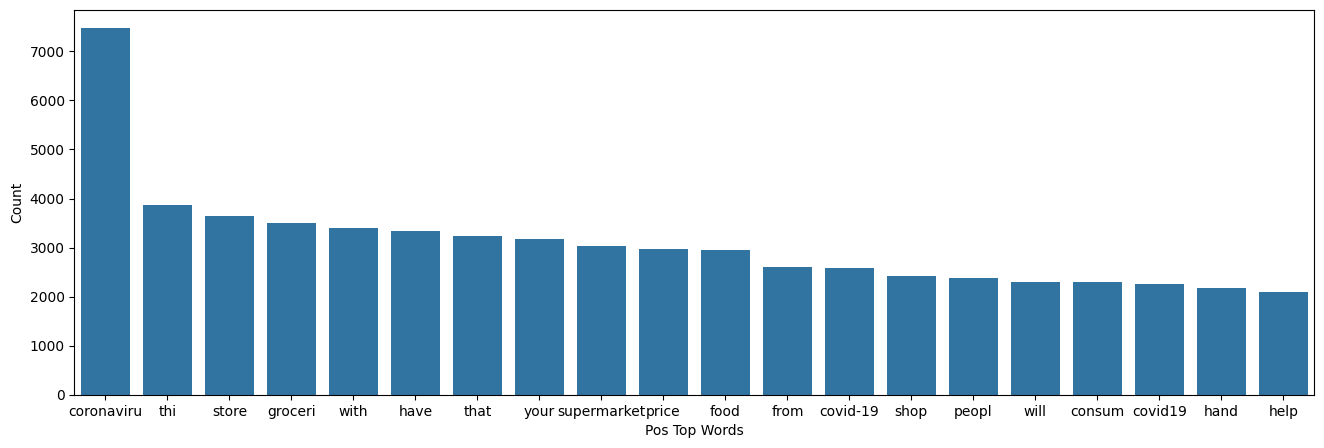

In [378]:
PosListOfWords = nltk.FreqDist(PosAllWordsAlone)
df3 = pd.DataFrame({'Pos Top Words': list(PosListOfWords.keys()), 'Count':list(PosListOfWords.values())})
df3 = df3.nlargest(columns='Count', n=20)
plt.figure(figsize=(16,5))
ax= sns.barplot(data=df3, x='Pos Top Words', y='Count')
ax.set(ylabel= 'Count')
plt.show()

In [379]:
for i in range(len(SegmentedTweet)):
    SegmentedTweet[i] = ' '.join(SegmentedTweet[i])
df['KeyTweet'] = SegmentedTweet
df.head()

,OriginalTweet,Sentiment,KeyTweet
0,TRENDING: New Yorkers encounter empty supermar...,0,trending: yorker encount empti supermarket she...
1,When I couldn't find hand sanitizer at Fred Me...,2,"when couldn't find hand sanit fred meyer, turn..."
2,Find out how you can protect yourself and love...,2,find protect yourself love one from coronavirus.
3,#Panic buying hits #NewYork City as anxious sh...,0,panic buy hit newyork citi anxiou shopper stoc...
4,#toiletpaper #dunnypaper #coronavirus #coronav...,1,toiletpap dunnypap coronaviru coronavirusaustr...


In [380]:
# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'coronaviru')
# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'covid-19')
# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'covid_19')
# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'covid19')

# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'thi')
# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'with')
# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'that')
# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'your')
# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'will')
# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'have')

# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'thi')
# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'thi')
# df['KeyTweet'] = np.vectorize(clean)(df['KeyTweet'],'thi')

In [381]:
AllWords = ' '.join([text for text in df['KeyTweet']])
NegWords = ' '.join([text for text in df['KeyTweet'][df['Sentiment']== (0)]])
NeutralWords = ' '.join([text for text in df['KeyTweet'][df['Sentiment']== (1)]])
PosWords = ' '.join([text for text in df['KeyTweet'][df['Sentiment']== (2)]])

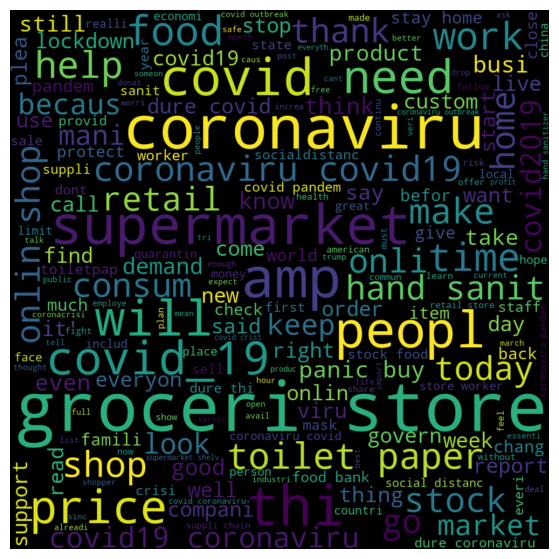

In [382]:
wordcloud = WordCloud(width=1000, height=1000, random_state=21, max_font_size=210).generate(AllWords)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

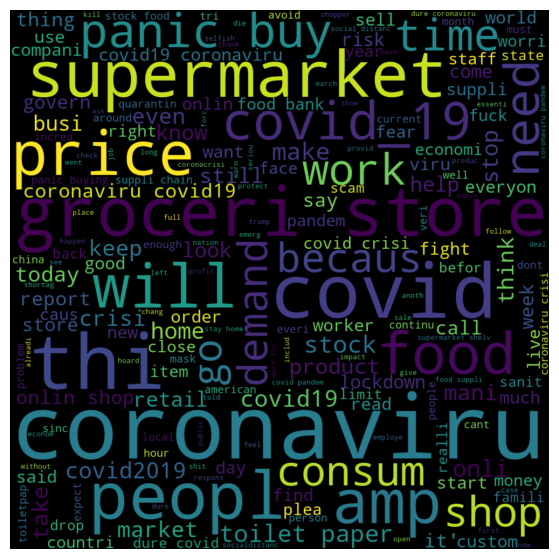

In [383]:
wordcloud1 = WordCloud(width=1000, height=1000, random_state=21, max_font_size=210).generate(NegWords)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud1,interpolation='bilinear')
plt.axis('off')
plt.show()

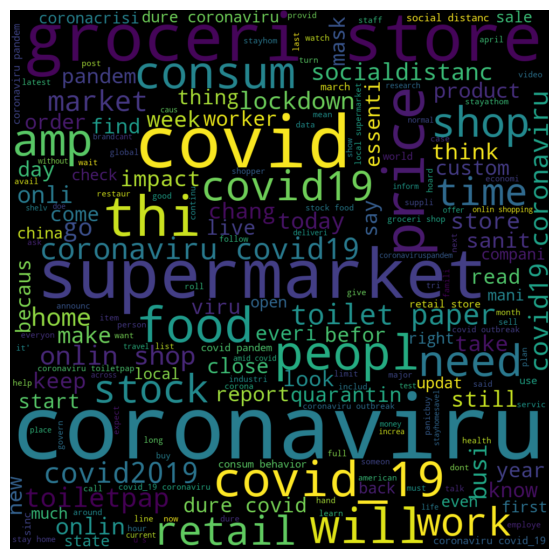

In [384]:
wordcloud2 = WordCloud(width=1000, height=1000, random_state=21, max_font_size=210).generate(NeutralWords)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud2,interpolation='bilinear')
plt.axis('off')
plt.show()

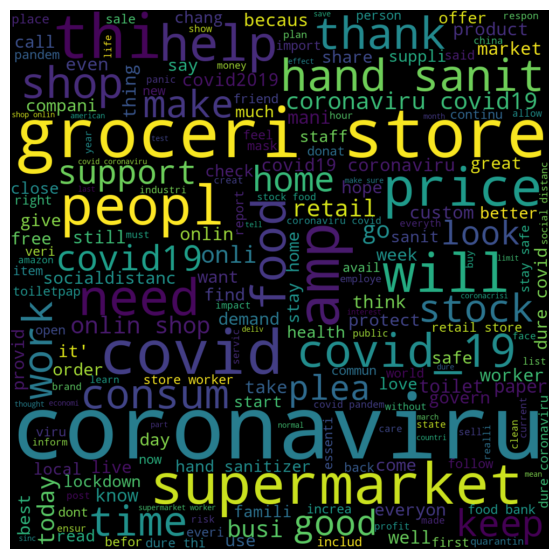

In [385]:
wordcloud3 = WordCloud(width=1000, height=1000, random_state=21, max_font_size=210).generate(PosWords)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud3,interpolation='bilinear')
plt.axis('off')
plt.show()

In [386]:
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(df['KeyTweet'])
bow.shape

(44699, 42412)

In [387]:
df = df.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(bow, df['Sentiment'], test_size=0.2, random_state=13)

In [388]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (35759, 42412)
X_test shape:  (8940, 42412)
y_train shape:  (35759,)
y_test shape:  (8940,)


In [389]:
# USING MULTINOMIAL NAIVE BAYES CLASSIFIER
Naive = MultinomialNB().fit(X_train, y_train)
PredictedNaive = Naive.predict(X_test)

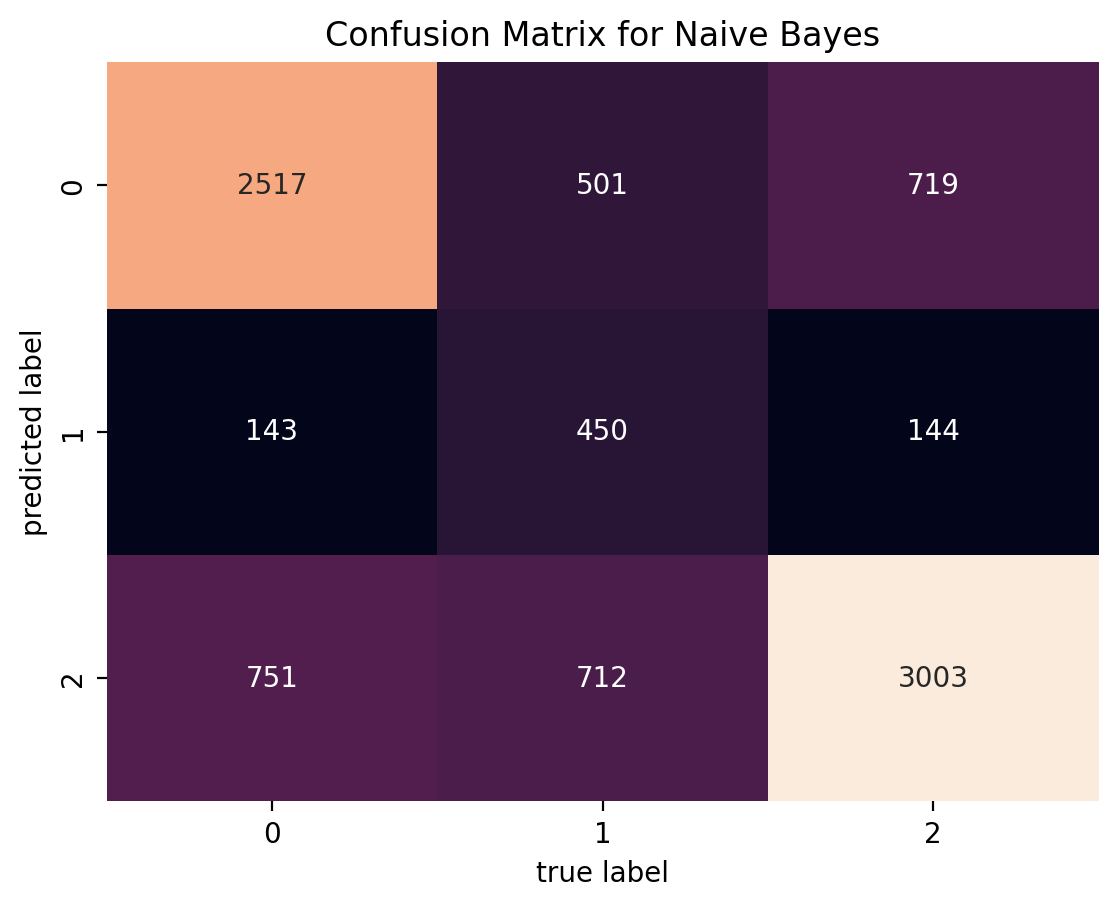

In [390]:
plt.figure(dpi=200)
mat = confusion_matrix(y_test, PredictedNaive)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

# plt.figure(figsize=(10,7))
plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [391]:
ScoreNaive = accuracy_score(PredictedNaive, y_test)
print('Accuracy with Naive Bayes: ', ScoreNaive)

Accuracy with Naive Bayes:  0.6677852348993288
